In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import lightcones.linalg as ll

In [2]:
epsilons = [0.1, 0.2]
alphas = [0.2, 0.2]
omegas = [1, 3]
dt = 0.01
t_past = 60
t_future = 60 

n_rel = 4

t_max = t_past + t_future

t_past_noise = t_past + t_future
t_max_noise = t_past_noise + t_future

t = np.arange(0, t_max_noise, dt)
n_t_max = len(t)

n_t_past = int(t_past / dt)
n_t_future = int(t_future / dt)

n_t_past_noise = int(t_past_noise / dt)

M = np.zeros(n_t_max) 
for i in range(n_t_max):
    tau = t[i] - t[0]
    for j in range(len(epsilons)):
        M[i] = M[i] + alphas[j] * math.exp(- epsilons[j] * abs(tau)) * math.cos(omegas[j] * abs(tau))

T = toeplitz(M)
L = cholesky(T, lower=True)

C = L[n_t_future:, n_t_future]

In [3]:
def apply_memory_matrix(x):
    x_out = np.zeros(n_t_past)
    for i in range(n_t_future):
        m = C[i:i+n_t_past]
        x_out = x_out + np.vdot(m, x) * m
    return x_out

memory_matrix = sparse.linalg.LinearOperator((n_t_past, n_t_past), matvec=apply_memory_matrix)

def ensure_phase(eigenvectors):
    eigenvectors_corrected = eigenvectors.copy()
    
    for i in range(eigenvectors.shape[1]):
        v = eigenvectors[:, i]
        idx_max = np.argmax(np.abs(v))
        
        if v[idx_max] < 0:
                eigenvectors_corrected[:, i] = -v         
    return eigenvectors_corrected

# zero approximation for relevant vectors
pi, v = eigsh(memory_matrix, k=n_rel, which='LM')
v = ensure_phase(v)

In [4]:
v_in = np.zeros(n_t_past)
v_in[0] = 1

def iterate(v):
    v_shifted = np.vstack((np.zeros(n_rel), v[:-1, :]))
    U = np.column_stack((v_in, v_shifted))
    rho = U.T.conj() @ (memory_matrix @ U)
    pi_, U_ = ll.find_eigs_descending(rho)
    U_ = ensure_phase(U_)
    v_ = U @ U_
    return pi_, U_, v_ 

In [5]:
v_ = np.copy(v)

for i in range(1000):
    pi_, U_, v_ = iterate(v_)
    v_ = v_[:,:-1]

In [6]:
Cv_ = v_.T @ C[:n_t_past]

In [7]:
mc_steps = 10000

xi = np.zeros((n_t_max, mc_steps))

for m in range(mc_steps):
    w = np.random.normal(size=n_t_max)
    v_state = np.zeros(n_rel)
    for i in range(0, n_t_max):
        v_in = w[i] 
        v_ = np.concatenate([[v_in], v_state])
        v_ = U_.T.conj() @ v_
        v_state = v_[:-1]
        xi[i, m] = np.vdot(Cv_, v_state)

In [8]:
n_t_max

18000

In [9]:
n_t_corr = 500
corr = np.zeros((n_t_corr, n_t_corr))

for m in range(mc_steps):
    for p in range(n_t_corr):
        for q in range(n_t_corr):
            corr[p, q] += xi[p - n_t_corr + n_t_max, m] * xi[q - n_t_corr + n_t_max, m]
            
corr = corr / mc_steps        

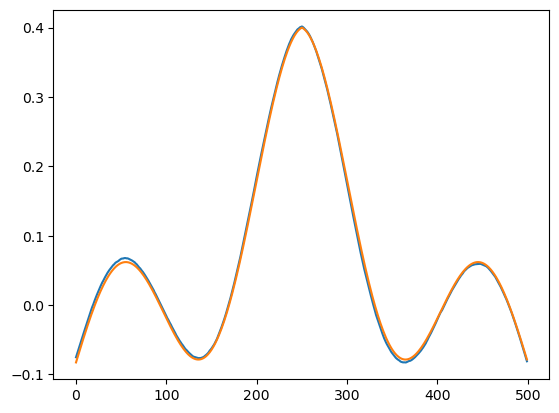

In [10]:
plt.plot(corr[round(n_t_corr/2), :])
plt.plot(np.concatenate((np.flip(M[1:round(n_t_corr/2)+1]), M[:round(n_t_corr/2)])))